# Home Credit Group

## Notebook Preparation

In [55]:
%matplotlib inline

# Standard libraries
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Third-party libraries
import featuretools as ft
import bokeh
from dask.distributed import Client, LocalCluster
from pandas.api.types import is_string_dtype, is_numeric_dtype
import optuna
import shap
import joblib
from lightgbm import LGBMClassifier
from boruta import BorutaPy
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder
)
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, precision_score, 
    recall_score, classification_report, RocCurveDisplay, 
    roc_auc_score, roc_curve
)

# Local imports
from src.utils import (
    count_duplicated_rows, age_year_bins, reduce_memory_usage_pd, 
    numeric_quantile_bins, convert_binary_values_custom, 
    feature_reduction_xgboost, remove_single_value_features, 
    train_test_valid_split, filter_existing_columns, 
    update_and_classify_features
)
from src import plot_utils

# Suppress all warnings
warnings.filterwarnings("ignore")

# Constants
RANDOM_STATE = 42

In [2]:
# Notebook styles
sns.set(style="darkgrid", palette="pastel")
palette_cmap = sns.color_palette("mako", as_cmap=True)
plt.rcParams["figure.figsize"] = [14, 6]

# Pandas configuration
pd.set_option("display.max_columns", None)

# Suppress all warnings
warnings.filterwarnings("ignore")

In [82]:
# Path to data files 
path_csv = "data/raw_csv"
path_parque = "data/raw_parquet"
path_filtered = "data/filtered"
path_models = "app/models"

## Feature Engineering 
As we already did some feature engineering in EDA part. We can implement few additional ones.
<br>
We will create some additional features which will bin our data.
<br>
Age will be binned into 7 bins.
Total income into 5 bins.

In [4]:
application_train = pd.read_parquet(f"{path_filtered}/application_train_eda.parquet", engine="pyarrow")

# Reducing dataframe memory
application_train = reduce_memory_usage_pd(application_train)

Memory before: 68.04 MB. 
Memory after: 51.03 MB.
Percent of reduction: (25.0% reduction)


In [5]:
application_train["BIN_AGE_GROUPS"] = age_year_bins(
    df=application_train, target_feature="AGE")

application_train["BIN_AMT_INCOME_TOTAL"] = numeric_quantile_bins(
    df=application_train, target_feature="AMT_INCOME_TOTAL")

Some of the features can be transformet to binary, as it have only 2 possible values.

In [6]:
application_train = convert_binary_values_custom(
    application_train, 
    ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "EMERGENCYSTATE_MODE"])

# Converting integer values to string
application_train["REGION_RATING_CLIENT_W_CITY"] = application_train["REGION_RATING_CLIENT_W_CITY"].astype(str)
application_train["REGION_RATING_CLIENT"] = application_train["REGION_RATING_CLIENT"].astype(str)

For all features which we will use, we will create separate list for them, which will be indicating feature type. This will help later on pipeline process.

In [7]:
binary_feature = [
    "REG_CITY_NOT_WORK_CITY", "FLAG_EMP_PHONE", "REG_CITY_NOT_LIVE_CITY", 
    "FLAG_DOCUMENT_3", "LIVE_CITY_NOT_WORK_CITY", "FLAG_DOCUMENT_6", 
    "FLAG_PHONE", "FLAG_DOCUMENT_16", 
    "FLAG_DOCUMENT_13", "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_8", "FLAG_DOCUMENT_18", 
    "REG_REGION_NOT_WORK_REGION", "FLAG_DOCUMENT_15", "REG_REGION_NOT_LIVE_REGION", 
    "FLAG_DOCUMENT_2", "FLAG_DOCUMENT_9", "FLAG_DOCUMENT_11", "FLAG_DOCUMENT_21", 
    "CODE_GENDER", "FLAG_OWN_CAR", "EMERGENCYSTATE_MODE", 
    "FLAG_OWN_REALTY", "NAME_CONTRACT_TYPE"]

categorical_feature = [
    "OCCUPATION_TYPE", "ORGANIZATION_TYPE", "NAME_INCOME_TYPE", 
    "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "NAME_TYPE_SUITE", 
    "WEEKDAY_APPR_PROCESS_START"]

numerical_feature_time = [
    "YEARS_OF_WORKING", "DAYS_LAST_PHONE_CHANGE", "YEARS_ID_PUBLISH", 
    "YEARS_REGISTRATION", "AMT_REQ_CREDIT_BUREAU_YEAR", "HOUR_APPR_PROCESS_START"]

numerical_feature_float = [
    "AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE", "DEF_30_CNT_SOCIAL_CIRCLE", 
    "DEF_60_CNT_SOCIAL_CIRCLE", "FLOORSMAX_AVG", "FLOORSMAX_MEDI", "AGE",
    "FLOORSMAX_MODE", "AMT_CREDIT", "TOTALAREA_MODE", "AMT_INCOME_TOTAL", 
    "AMT_ANNUITY", "AMT_REQ_CREDIT_BUREAU_MON", "CNT_CHILDREN", "CNT_FAM_MEMBERS",
    "OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "YEARS_BEGINEXPLUATATION_MEDI", 
    "YEARS_BEGINEXPLUATATION_AVG", "YEARS_BEGINEXPLUATATION_MODE", "EXT_SOURCE_2", "EXT_SOURCE_3"]

ordinal_order = {
    "REGION_RATING_CLIENT_W_CITY": ["3", "2", "1"],
    "REGION_RATING_CLIENT": ["3", "2", "1"], 
    "NAME_EDUCATION_TYPE": [
        "Lower secondary",
        "Secondary / secondary special",
        "Incomplete higher",
        "Higher education",
        "Academic degree"
    ],
    "BIN_AGE_GROUPS": ['0-18', '19-25', '26-35', '36-45', '46-55', '55-65', '65+'],
    "BIN_AMT_INCOME_TOTAL": ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
}

ordinal_feature = list(ordinal_order.keys())
ordinal_categories = list(ordinal_order.values())
engineered_features_basic = (
    binary_feature + categorical_feature + numerical_feature_time + 
    numerical_feature_float + list(ordinal_order.keys()))


ordinal_categories = [ordinal_order[col] for col in application_train[ordinal_feature]]

target_feature = ["TARGET"]

As we have generated few additional features, we can inspect distribution of them.

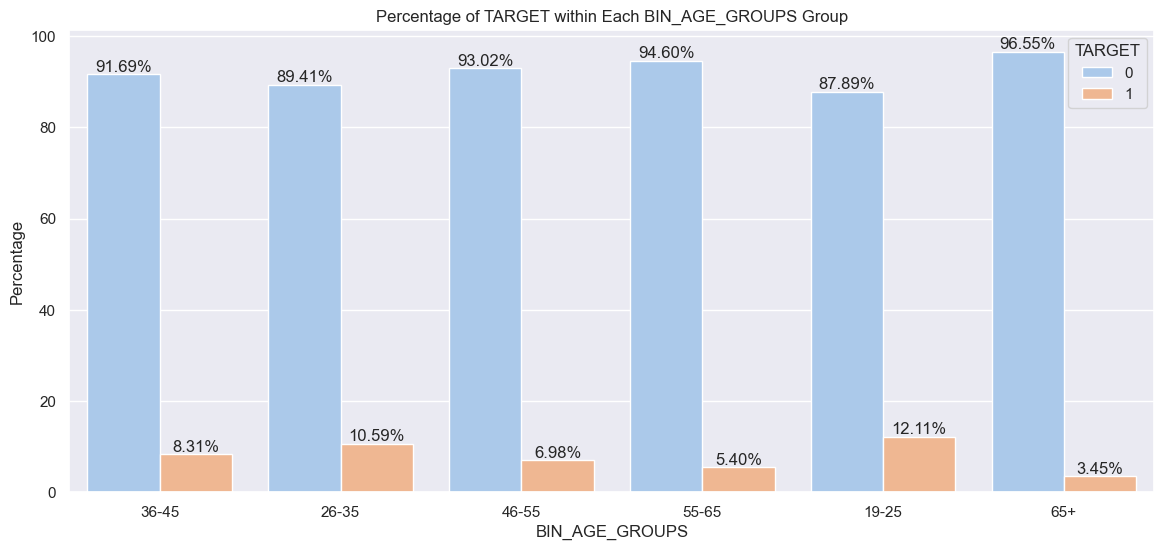

<Figure size 1400x600 with 0 Axes>

In [8]:
plot_utils.plot_percentage_bars_categorical(
    application_train, "BIN_AGE_GROUPS", "TARGET", max_values=6)

Age groups indicate that older people have higher percent to get the loan, age groups have about 1.5% - 2% difference. If we check first the youngest and last the oldest people in groups, we see about ~9% difference.

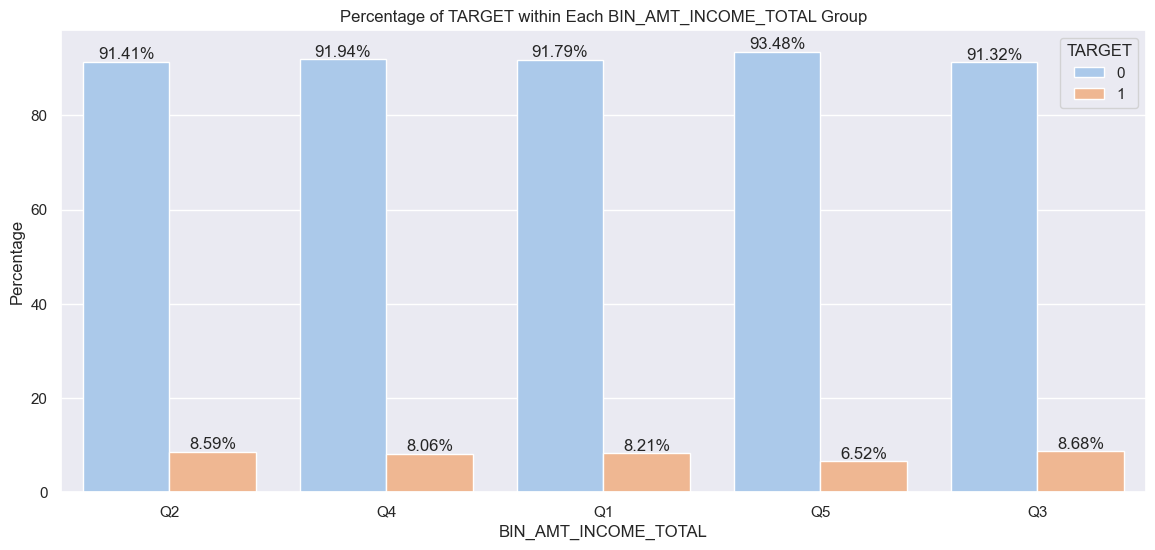

<Figure size 1400x600 with 0 Axes>

In [9]:
plot_utils.plot_percentage_bars_categorical(
    application_train, "BIN_AMT_INCOME_TOTAL", "TARGET", max_values=6)

Income is also indicating order, it shows that highest earning group have the biggest percentage to get the loan.
<br>
93.48% for group Q5 and 91.79% for group Q1, about ~2% difference between first and last group.

### Joining additional datasets

Our dataset is divided into separate files, we will combine all tables automatically using feature tools, which will cut a lot of time from feature engineering part.

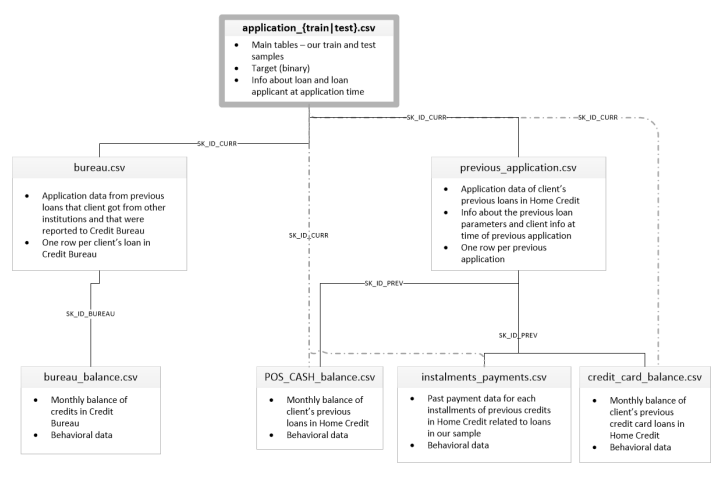

In [10]:
import featuretools as ft
from woodwork.logical_types import Boolean


In [11]:
bureau = reduce_memory_usage_pd(
    pd.read_parquet(
        f"{path_parque}/bureau.parquet", 
        engine="pyarrow").replace({365243: np.nan}))

bureau_balance = reduce_memory_usage_pd(
    pd.read_parquet(
        f"{path_parque}/bureau_balance.parquet",
        engine="pyarrow").replace({365243: np.nan}))

pos_cash_balance = reduce_memory_usage_pd(
    pd.read_parquet(
        f"{path_parque}/POS_CASH_balance.parquet", 
        engine="pyarrow").replace({365243: np.nan}))

credit_card_balance = reduce_memory_usage_pd(
    pd.read_parquet(
        f"{path_parque}/credit_card_balance.parquet", 
        engine="pyarrow").replace({365243: np.nan}))

previous_application = reduce_memory_usage_pd(
    pd.read_parquet(
        f"{path_parque}/previous_application.parquet", 
        engine="pyarrow").replace({365243: np.nan}))

installments_payments = reduce_memory_usage_pd(
    pd.read_parquet(
        f"{path_parque}/installments_payments.parquet", 
        engine="pyarrow").replace({365243: np.nan}))

Memory before: 222.62 MB. 
Memory after: 85.12 MB.
Percent of reduction: (61.8% reduction)
Memory before: 624.85 MB. 
Memory after: 156.21 MB.
Percent of reduction: (75.0% reduction)
Memory before: 610.43 MB. 
Memory after: 209.84 MB.
Percent of reduction: (65.6% reduction)
Memory before: 673.88 MB. 
Memory after: 292.99 MB.
Percent of reduction: (56.5% reduction)
Memory before: 471.48 MB. 
Memory after: 146.55 MB.
Percent of reduction: (68.9% reduction)
Memory before: 830.41 MB. 
Memory after: 389.25 MB.
Percent of reduction: (53.1% reduction)


To join data frames we need to be sure that all unique index data types for all datasets are the same. 

In [12]:
dataset_list = [
    application_train, bureau, 
    bureau_balance, pos_cash_balance, credit_card_balance, 
    previous_application, installments_payments]

index_list = ["SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV"]

for index in index_list:
    for df in dataset_list:
        if index in list(df.columns):
            df[index] = df[index].fillna(0).astype(np.int64)

Now we also want to remove additional connections between tables, leaving only maximum 2 connection per table. One connection which indicates main table and second which indicates tail table.

In [13]:
pos_cash_balance = pos_cash_balance.drop(columns=["SK_ID_CURR"])
credit_card_balance = credit_card_balance.drop(columns=["SK_ID_CURR"])
installments_payments = installments_payments.drop(columns=["SK_ID_CURR"])

Transforming features to boolean type if they have only 2 unique values.

In [14]:
# Cluster dashboard
cluster = LocalCluster(diagnostics_port=8787) 

In [15]:
application_log_types = {}

for col in application_train:
    if application_train[col].nunique() == 2 and application_train[col].isnull().any() == False:
        application_log_types[col] = Boolean

To join data frames we will create feature tools entity, which will hold data frames and connections between them.

In [16]:
ft_ent_set = ft.EntitySet(id="uniq_id")

In [17]:
ft_ent_set = ft_ent_set.add_dataframe(
    dataframe=application_train,
    dataframe_name="application_train",
    index="SK_ID_CURR",
    logical_types=application_log_types,
)

ft_ent_set = ft_ent_set.add_dataframe(
    dataframe=bureau, 
    dataframe_name="bureau", 
    index="SK_ID_BUREAU"
)

ft_ent_set = ft_ent_set.add_dataframe(
    dataframe=previous_application, 
    dataframe_name="previous_application", 
    index="SK_ID_PREV"
)

ft_ent_set = ft_ent_set.add_dataframe(
    dataframe=bureau_balance,
    dataframe_name="bureau_balance",
    make_index=True,
    index="bureau_balance_index",
)

ft_ent_set = ft_ent_set.add_dataframe(
    dataframe=credit_card_balance, 
    dataframe_name="credit_card_balance", 
    make_index=True, 
    index="credit_index"
)

ft_ent_set = ft_ent_set.add_dataframe(
    dataframe=installments_payments,
    dataframe_name="installments_payments",
    make_index=True,
    index="installment_index",
)

ft_ent_set = ft_ent_set.add_dataframe(
    dataframe=pos_cash_balance, 
    dataframe_name="pos_cash_balance", 
    make_index=True, 
    index="pos_index"
)

In [18]:
ft_ent_set.add_relationship(
    "application_train", "SK_ID_CURR", "bureau", "SK_ID_CURR")
ft_ent_set.add_relationship(
    "bureau", "SK_ID_BUREAU", "bureau_balance", "SK_ID_BUREAU")
ft_ent_set.add_relationship(
    "application_train", "SK_ID_CURR", "previous_application", "SK_ID_CURR")

ft_ent_set.add_relationship(
    "previous_application", "SK_ID_PREV", "credit_card_balance", "SK_ID_PREV")
ft_ent_set.add_relationship(
    "previous_application", "SK_ID_PREV", "installments_payments", "SK_ID_PREV")
ft_ent_set.add_relationship(
    "previous_application", "SK_ID_PREV", "pos_cash_balance", "SK_ID_PREV")

Entityset: uniq_id
  DataFrames:
    application_train [Rows: 307511, Columns: 83]
    bureau [Rows: 1716428, Columns: 17]
    previous_application [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    credit_card_balance [Rows: 3840312, Columns: 23]
    installments_payments [Rows: 13605401, Columns: 8]
    pos_cash_balance [Rows: 10001358, Columns: 8]
  Relationships:
    bureau.SK_ID_CURR -> application_train.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous_application.SK_ID_CURR -> application_train.SK_ID_CURR
    credit_card_balance.SK_ID_PREV -> previous_application.SK_ID_PREV
    installments_payments.SK_ID_PREV -> previous_application.SK_ID_PREV
    pos_cash_balance.SK_ID_PREV -> previous_application.SK_ID_PREV

As we have defined all frames and connections, we now set up additional columns, which will be created by feature tools.

In [19]:
# We will use agg primitives which are less compute power consuming due to memory efficiency
full_data, feature_names = ft.dfs(
    entityset=ft_ent_set,
    target_dataframe_name="application_train",
    agg_primitives=[
        "Count", "Min", 
        "Max", "Mean", 
        "Sum", # Less compute aggresive all before
        #"Median", "Std", # More compute aggresive below
        #"NumUnique", "PercentTrue", "Mode"
    ],
    max_depth=2,
    features_only=False,
    verbose=True
)

Built 1044 features
Elapsed: 01:27 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [20]:
cluster.close()

In [21]:
full_data.shape

(307511, 1044)

Our dataset become way heavier and bigger than before, but as we can see row number still the same as before, let's go step by step and reduce feature number.
<br>
As we joined all data frames to one we need to perform additional cleaning, by removing new duplicates values, high missing value columns.

### Duplicate values check

In [22]:
count_duplicated_rows(full_data)

The DataFrame contains 0 duplicated rows.


### Missing values check
Let's inspect missing values and drop columns which have high missing values percentage, for the threshold we will set 0.5, so if column have more than 50% of missing values we will drop it out.

In [23]:
full_data = ft.selection.remove_highly_null_features(
    full_data, pct_null_threshold=0.5)

full_data.shape

(307511, 711)

### Single value check
For safety, we will remove features which hold only one unique value which is not null. As this feature will not give us any useful information.

In [24]:
full_data = ft.selection.remove_single_value_features(
    full_data, count_nan_as_value=False)

full_data.shape

(307511, 702)

### Correlated features check
We can check our feature correlation and also remove those features which are highly correlated, we will use threshold 0.9.

In [25]:
full_data = ft.selection.remove_highly_correlated_features(
    full_data, pct_corr_threshold=0.9, features_to_keep=["TARGET"])

full_data.shape

(307511, 344)

### Important feature check
For this task, we will use XGBoost to reduce our feature by importance.

In [26]:
feature_reduction_x = full_data.drop(columns=["TARGET"])
feature_reduction_y = full_data["TARGET"]

In [27]:
important_features = feature_reduction_xgboost(
    feature_reduction_x, feature_reduction_y, threshold=1)

important_features

,Feature,Importance
0,ORGANIZATION_TYPE,641.0
1,OCCUPATION_TYPE,195.0
2,EXT_SOURCE_3,123.0
3,EXT_SOURCE_2,115.0
4,AMT_CREDIT,90.0
...,...,...
253,MEAN(bureau.CREDIT_DAY_OVERDUE),2.0
254,MIN(previous_application.SUM(pos_cash_balance....,2.0
255,MIN(previous_application.SUM(pos_cash_balance....,2.0
256,MIN(previous_application.CNT_PAYMENT),2.0


We lower our feature number multiple times, it is great, as we remove highly correlated, nullable and single value features from our dataset just by using few lines of code. 

In [28]:
feature_list = important_features["Feature"].tolist()
feature_matrix = full_data.copy()

In [29]:
feature_matrix[feature_list].head(3)

,ORGANIZATION_TYPE,OCCUPATION_TYPE,EXT_SOURCE_3,EXT_SOURCE_2,AMT_CREDIT,AMT_ANNUITY,MAX(bureau.DAYS_CREDIT),MAX(bureau.DAYS_ENDDATE_FACT),MAX(previous_application.DAYS_LAST_DUE),MAX(bureau.DAYS_CREDIT_ENDDATE),MAX(previous_application.DAYS_LAST_DUE_1ST_VERSION),MAX(installments_payments.DAYS_ENTRY_PAYMENT),AGE,WEEKDAY_APPR_PROCESS_START,TOTALAREA_MODE,MAX(bureau.AMT_CREDIT_MAX_OVERDUE),MEAN(bureau.DAYS_CREDIT),MEAN(bureau.AMT_CREDIT_SUM),MEAN(bureau.AMT_CREDIT_SUM_DEBT),MAX(previous_application.DAYS_DECISION),DAYS_LAST_PHONE_CHANGE,MAX(bureau.DAYS_CREDIT_UPDATE),MIN(bureau.AMT_CREDIT_SUM),MEAN(previous_application.SELLERPLACE_AREA),SUM(previous_application.MEAN(credit_card_balance.CNT_DRAWINGS_ATM_CURRENT)),MAX(bureau.AMT_CREDIT_SUM),YEARS_BEGINEXPLUATATION_AVG,YEARS_OF_WORKING,MAX(previous_application.AMT_DOWN_PAYMENT),MIN(installments_payments.AMT_INSTALMENT),MAX(previous_application.DAYS_FIRST_DUE),MIN(bureau.DAYS_CREDIT_ENDDATE),YEARS_REGISTRATION,MEAN(bureau.DAYS_CREDIT_ENDDATE),MAX(installments_payments.AMT_INSTALMENT),NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,SUM(bureau.AMT_CREDIT_SUM),MEAN(previous_application.HOUR_APPR_PROCESS_START),MIN(previous_application.MAX(installments_payments.AMT_INSTALMENT)),MIN(bureau.DAYS_ENDDATE_FACT),MEAN(pos_cash_balance.CNT_INSTALMENT),MEAN(previous_application.MIN(installments_payments.AMT_INSTALMENT)),MAX(previous_application.SELLERPLACE_AREA),MIN(bureau.DAYS_CREDIT_UPDATE),YEARS_ID_PUBLISH,MAX(bureau.AMT_CREDIT_SUM_DEBT),MIN(previous_application.DAYS_DECISION),MEAN(previous_application.CNT_PAYMENT),MEAN(previous_application.MAX(installments_payments.AMT_INSTALMENT)),MIN(previous_application.AMT_GOODS_PRICE),MEAN(bureau.DAYS_CREDIT_UPDATE),MAX(previous_application.RATE_DOWN_PAYMENT),MEAN(installments_payments.previous_application.AMT_ANNUITY),MIN(bureau.DAYS_CREDIT),MEAN(previous_application.SUM(pos_cash_balance.MONTHS_BALANCE)),AMT_INCOME_TOTAL,MEAN(installments_payments.NUM_INSTALMENT_VERSION),MAX(previous_application.MIN(installments_payments.AMT_INSTALMENT)),MIN(previous_application.SUM(installments_payments.DAYS_ENTRY_PAYMENT)),MIN(previous_application.MEAN(installments_payments.AMT_INSTALMENT)),MIN(previous_application.SUM(pos_cash_balance.MONTHS_BALANCE)),MEAN(previous_application.COUNT(pos_cash_balance)),MAX(previous_application.MIN(pos_cash_balance.CNT_INSTALMENT_FUTURE)),MEAN(previous_application.SUM(installments_payments.AMT_INSTALMENT)),MEAN(previous_application.MIN(pos_cash_balance.CNT_INSTALMENT_FUTURE)),MEAN(previous_application.AMT_ANNUITY),CODE_GENDER,MEAN(previous_application.AMT_APPLICATION),MEAN(previous_application.COUNT(installments_payments)),MAX(previous_application.AMT_ANNUITY),SUM(installments_payments.previous_application.AMT_APPLICATION),MIN(installments_payments.previous_application.AMT_APPLICATION),MEAN(installments_payments.NUM_INSTALMENT_NUMBER),MEAN(previous_application.DAYS_DECISION),MIN(previous_application.AMT_ANNUITY),SUM(bureau.DAYS_CREDIT_ENDDATE),MEAN(previous_application.SUM(installments_payments.NUM_INSTALMENT_NUMBER)),MEAN(previous_application.RATE_DOWN_PAYMENT),HOUR_APPR_PROCESS_START,SUM(previous_application.AMT_ANNUITY),SUM(previous_application.DAYS_DECISION),MAX(previous_application.AMT_APPLICATION),MEAN(previous_application.MEAN(installments_payments.NUM_INSTALMENT_NUMBER)),MIN(previous_application.RATE_DOWN_PAYMENT),MIN(previous_application.HOUR_APPR_PROCESS_START),OBS_30_CNT_SOCIAL_CIRCLE,SUM(previous_application.DAYS_FIRST_DUE),SUM(previous_application.MAX(pos_cash_balance.CNT_INSTALMENT)),MAX(installments_payments.previous_application.AMT_APPLICATION),MAX(installments_payments.previous_application.AMT_ANNUITY),FLOORSMAX_AVG,SUM(credit_card_balance.previous_application.SELLERPLACE_AREA),MIN(previous_application.MAX(pos_cash_balance.CNT_INSTALMENT)),MEAN(previous_application.MIN(pos_cash_balance.CNT_INSTALMENT)),MEAN(previous_application.SUM(installments_payments.NUM_INSTALMENT_VERSION)),MEAN(previous_application.MEAN(installments_

Now, as we get additional features, we need to fill our feature list defined before with additional ones.

In [30]:
# As project is quite compute intense we create separate checkpoint to save preprocess data
feature_matrix.to_parquet(
    f"{path_filtered}/data_preprocess.parquet",
    engine="pyarrow")

In [31]:
feature_matrix = reduce_memory_usage_pd(
    pd.read_parquet(f"{path_filtered}/data_preprocess.parquet",
                    engine="pyarrow").reset_index(drop=True))

Memory before: 735.51 MB. 
Memory after: 325.24 MB.
Percent of reduction: (55.8% reduction)


In [32]:
# Filter existing columns from the provided lists
binary_feature = filter_existing_columns(
    feature_matrix, binary_feature)

categorical_feature = filter_existing_columns(
    feature_matrix, categorical_feature)

numerical_feature_float = filter_existing_columns(
    feature_matrix, numerical_feature_float)

numerical_feature_time = filter_existing_columns(
    feature_matrix, numerical_feature_time)

ordinal_feature = filter_existing_columns(
    feature_matrix, ordinal_feature)

In [33]:
feature_matrix, binary_feature, categorical_feature, numerical_feature_float = (
    update_and_classify_features(
        df=feature_matrix, 
        binary_feature=binary_feature, 
        categorical_feature=categorical_feature, 
        numerical_feature=numerical_feature_float)
)

In [34]:
binary_feature.remove("TARGET")

We need to perform check for all features if theyr data type is good before moving forward.

In [35]:
# Select columns that are NOT of type bool or boolean
feature_matrix[binary_feature].select_dtypes(exclude=["bool"]).any()

EMERGENCYSTATE_MODE    True
dtype: bool

Those features have only 2 unique values, they will be transformed automatically later.

In [36]:
# Select columns that are NOT of type object or category
feature_matrix[categorical_feature].select_dtypes(exclude=["object", "category"]).any()

Series([], dtype: bool)

In [37]:
# Select columns that are NOT of type float or int
feature_matrix[numerical_feature_float].select_dtypes(
    exclude=["float64", "float32", "float16", "int64", "int32", "int16", "int8"]).any()

Series([], dtype: bool)

In [38]:
# Select columns that are NOT of type float or int
feature_matrix[numerical_feature_time].select_dtypes(
    exclude=["float64", "float32", "float16", "int64", "int32", "int16", "int8"]).any()

Series([], dtype: bool)

In [39]:
feature_matrix[ordinal_feature].select_dtypes(exclude=["object", "category"]).any()

REGION_RATING_CLIENT    True
dtype: bool

In [40]:
feature_matrix[ordinal_feature].dtypes

REGION_RATING_CLIENT        int8
NAME_EDUCATION_TYPE     category
BIN_AGE_GROUPS          category
BIN_AMT_INCOME_TOTAL    category
dtype: object

We will change data type for REGION_RATING_CLIENT column and also remove missing values from ordinal_order list.

In [41]:
feature_matrix["REGION_RATING_CLIENT"] = (
    feature_matrix["REGION_RATING_CLIENT"].astype("category"))

In [42]:
ordinal_order = {
    key: value
    for key, value in ordinal_order.items()
    if key in feature_matrix[ordinal_feature].columns
}

In [43]:
features_to_use = list(
    set(
        binary_feature +
        categorical_feature +
        numerical_feature_time +
        numerical_feature_float +
        ordinal_feature +
        target_feature
    )
)

# Save filtered dataframe into seperate files
feature_matrix = feature_matrix[features_to_use]
feature_matrix.to_parquet(
    f"{path_filtered}/filtered_data.parquet", 
    engine="pyarrow")


### Feature Engineering Summary 
<br>
<li>Data types were changed and down cast to reduce memory, reducing memory about 50-60% for each file.</li>
<li>Bins for features "BIN_AGE_GROUPS, BIN_AMT_INCOME_TOTAL" were created.</li>
<li>Age groups indicate that older people have higher percent to get the loan, age groups have about 1.5% - 2% difference.</li>
<li>Manually pick features from EDA hypothesis testing and put in defined lists.</li>
<li>Income is also indicating order, it shows that highest earning group have the biggest percentage to get the loan.</li>
<li>Using Feature Tools, we combine all datasets base by unique ID.</li>
<li>No duplicate values found.</li>
<li>Removed highly correlated features.</li>
<li>Removed features which have only one value.</li>
<li>Removed features which have more than 50% of missing values.</li>
<li>Use XGBoost to pick only important features.</li>
<li>Automatically put features to the defined lists.</li>

## Machine Learning Models
In this part, we will create a Machine Learning model which will predict the Target variable in our dataset.
<br>
We will split our train dataset to train and valid, so later test set can be used for testing.

In [44]:
model_scores = []

In [45]:
data_train = pd.read_parquet(
    f"{path_filtered}/filtered_data.parquet", 
    engine="pyarrow").reset_index(drop=True) 

# Reducing dataframe memory
data_train = reduce_memory_usage_pd(data_train)

Memory before: 325.24 MB. 
Memory after: 325.24 MB.
Percent of reduction: (0.0% reduction)


In [46]:
y = data_train["TARGET"]
x = data_train.drop(columns=["TARGET"]).reset_index(drop=True)   

x_train, x_test, x_valid, y_train, y_test, y_valid = train_test_valid_split(
    x, y, 
    test_split_size=0.2, 
    ran_state=RANDOM_STATE, 
    size=1
)

Training set shape: (184506, 343)
Validation set shape: (61502, 343)
Test set shape: (61503, 343)


In EDA step, we saw that some of the features have widely scaled, so we will use StandardScaler to standardize features by removing the mean and scaling to unit variance.
<br>
To encode categorical features as an integer array, OneHotEncoder will be used.
<br>
We have features which provides order for his OrdinalEncoder will be used.
<br>
We will wrap those steps to pipeline to make our models scalable.

In [47]:
# Creating pipelines with transformer
bin_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(
            strategy="most_frequent"))
    ])

num_transformer_time = Pipeline(
    steps=[
        ("imputer", SimpleImputer(
            strategy="median")),
        ("scaler", StandardScaler())
    ])

num_transformer_float = Pipeline(
    steps=[
        ("imputer", SimpleImputer(
            strategy="mean")), 
        ("scaler", StandardScaler())
    ])

cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(
            strategy="most_frequent")),
        ("encoder", OneHotEncoder(
            handle_unknown="ignore", 
            sparse_output=False)) 
    ])

ord_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(
            strategy="most_frequent")),
        ("encoder", OrdinalEncoder(
            categories='auto', 
            handle_unknown="use_encoded_value", 
            unknown_value=-1))
    ])

In [48]:
# Combining all numerical transformations into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric_time", num_transformer_time, numerical_feature_time), 
        ("numeric_float", num_transformer_float, numerical_feature_float),
        ("categorical", cat_transformer, categorical_feature),
        ("ordinal", ord_transformer, ordinal_feature),
        ("binary", bin_transformer, binary_feature)
    ])

As we prepared pipelines for the model, first we need to create a baseline for the model, for this we will use Dummy Classifier which will predict most frequent class using simple strategies.

### Baseline Dummy Model

In [49]:
# Dummy model
dummy_model = DummyClassifier(strategy="stratified")

# Dummy pipeline
dummy_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("model", dummy_model)])

# Fitting dummy model with data
dummy_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YEARS_OF_WORKING',
                                                   'DAYS_LAST_PHONE_CHANGE',
                                                   'YEARS_ID_PUBLISH',
                                                   'YEARS_REGISTRATION',
                                                   'AMT_REQ_CREDIT_BUREAU_YEAR',
                                                   'HOUR_APPR_PROCESS_START']),
                                                 ('numeric_float',
                                                  Pipeline(steps=[('im...
                                                   'REG_REGION_NOT_LIVE_REGION',
                                                   'FLAG_DOCUMENT_2',
                                                   'FLAG_DOCUMENT_9',
                                                   'FLAG_DOCUMENT_11',
                                                   'FLAG_DOCUMENT_21',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'EMERGENCYSTATE_MODE',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_CONTRACT_TYPE',
                                                   'FLAG_MOBIL',
                                                   'FLAG_WORK_PHONE',
                                                   'FLAG_CONT_MOBILE',
                                                   'FLAG_EMAIL',
                                                   'LIVE_REGION_NOT_WORK_REGION',
                                                   'FLAG_DOCUMENT_4', ...])])),
                ('model', DummyClassifier(strategy='stratified'))])

In [50]:
# Making baseline predictions 
dummy_predictions = dummy_pipeline.predict(x_test)

print(f"Precision: {precision_score(y_test, dummy_predictions, average='binary')}")
print(f"Recall: {recall_score(y_test, dummy_predictions, average='binary')}")
print(f"F1 Score: {f1_score(y_test, dummy_predictions, average='binary')}")

Precision: 0.07598184329978291
Recall: 0.07754279959718026
F1 Score: 0.07675438596491228


### Baseline Logistic Regression Model

In [51]:
# LogisticRegression dummy model
log_model = LogisticRegression(random_state=RANDOM_STATE)

# Logistic pipeline
log_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("model", log_model)])
log_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YEARS_OF_WORKING',
                                                   'DAYS_LAST_PHONE_CHANGE',
                                                   'YEARS_ID_PUBLISH',
                                                   'YEARS_REGISTRATION',
                                                   'AMT_REQ_CREDIT_BUREAU_YEAR',
                                                   'HOUR_APPR_PROCESS_START']),
                                                 ('numeric_float',
                                                  Pipeline(steps=[('im...
                                                   'REG_REGION_NOT_LIVE_REGION',
                                                   'FLAG_DOCUMENT_2',
                                                   'FLAG_DOCUMENT_9',
                                                   'FLAG_DOCUMENT_11',
                                                   'FLAG_DOCUMENT_21',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'EMERGENCYSTATE_MODE',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_CONTRACT_TYPE',
                                                   'FLAG_MOBIL',
                                                   'FLAG_WORK_PHONE',
                                                   'FLAG_CONT_MOBILE',
                                                   'FLAG_EMAIL',
                                                   'LIVE_REGION_NOT_WORK_REGION',
                                                   'FLAG_DOCUMENT_4', ...])])),
                ('model', LogisticRegression(random_state=42))])

In [52]:
y_pred_log = log_pipeline.predict(x_test)

# Evaluate performance
print(f"Precision: {precision_score(y_test, y_pred_log)}")
print(f"Recall: {recall_score(y_test, y_pred_log)}")
print(f"F1 Score: {f1_score(y_test, y_pred_log)}")

Precision: 0.573170731707317
Recall: 0.0283987915407855
F1 Score: 0.05411629245826137


### Baseline Light Gradient Boosting Machine Model

In [56]:
# Light Gradient Boosting Machine (LGBM) dummy model
lgbm_dummy_model = LGBMClassifier(verbosity=-1, random_state=RANDOM_STATE)

# LGBM pipeline
lgbm_dummy_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("model", lgbm_dummy_model)])

# Fitting dummy model with data
lgbm_dummy_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YEARS_OF_WORKING',
                                                   'DAYS_LAST_PHONE_CHANGE',
                                                   'YEARS_ID_PUBLISH',
                                                   'YEARS_REGISTRATION',
                                                   'AMT_REQ_CREDIT_BUREAU_YEAR',
                                                   'HOUR_APPR_PROCESS_START']),
                                                 ('numeric_float',
                                                  Pipeline(steps=[('im...
                                                   'REG_REGION_NOT_LIVE_REGION',
                                                   'FLAG_DOCUMENT_2',
                                                   'FLAG_DOCUMENT_9',
                                                   'FLAG_DOCUMENT_11',
                                                   'FLAG_DOCUMENT_21',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'EMERGENCYSTATE_MODE',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_CONTRACT_TYPE',
                                                   'FLAG_MOBIL',
                                                   'FLAG_WORK_PHONE',
                                                   'FLAG_CONT_MOBILE',
                                                   'FLAG_EMAIL',
                                                   'LIVE_REGION_NOT_WORK_REGION',
                                                   'FLAG_DOCUMENT_4', ...])])),
                ('model', LGBMClassifier(random_state=42, verbosity=-1))])

In [57]:
lgbm_pred_log = lgbm_dummy_pipeline.predict(x_test)

# Evaluate performance
print(f"Precision: {precision_score(y_test, lgbm_pred_log)}")
print(f"Recall: {recall_score(y_test, lgbm_pred_log)}")
print(f"F1 Score: {f1_score(y_test, lgbm_pred_log)}")

Precision: 0.5893536121673004
Recall: 0.03121852970795569
F1 Score: 0.05929609793420046


### Dummy Model Evaluation

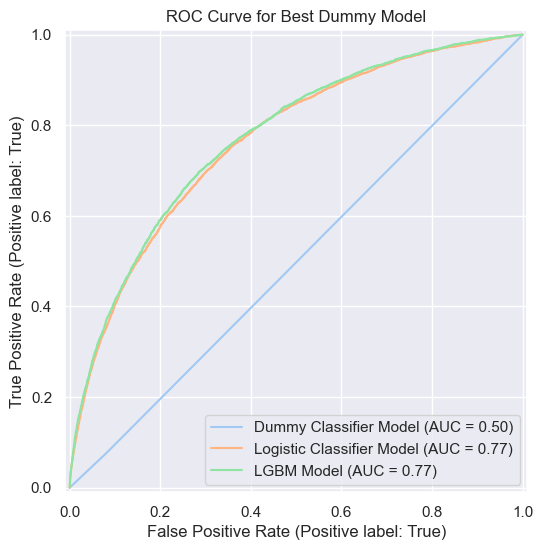

<Figure size 1400x600 with 0 Axes>

In [58]:
# Plot ROC
fig, ax = plt.subplots()


RocCurveDisplay.from_estimator(dummy_pipeline, x_test, y_test, ax=ax, name="Dummy Classifier Model")
RocCurveDisplay.from_estimator(log_pipeline, x_test, y_test, ax=ax, name="Logistic Classifier Model")
RocCurveDisplay.from_estimator(lgbm_dummy_pipeline, x_test, y_test, ax=ax, name="LGBM Model")

# Add labels and title
plt.title(f'ROC Curve for Best Dummy Model')
plt.show()
plt.tight_layout()

We set our baseline AUC for the model, it is quite high already, but we can use hyperparameter tuning to get better result. LGBM Model have a little bit higher ROC curve, but as this model is more efficient by speed, and it also handles missing value automatically we will use this model to for main model.

### Main Model Selection

Okay, we get our threshold, which will be our baseline for models.

We will create LGBM model as it is quick and can handle missing values and categorical values without additional tuning.

<b>Light Gradient Boosting Machine (LGBM)</b>
<li>LGBM is fast model having high training speed and high efficiency</li>
<li>Model handles categorical columns and provides high combinations of hyperparameter tuning.</li>

In [59]:
def objective(trial):
    # Define the hyperparameter search space
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=50),
    }

    # Create and train the LightGBM model
    model = lgb.LGBMClassifier(**param, verbosity=-1)
    model.fit(x_train, y_train)

    # Validate the model
    y_pred = model.predict_proba(x_valid)[:, 1] 
    roc_auc = roc_auc_score(y_valid, y_pred)

    return roc_auc

In [60]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2024-10-13 21:32:23,832] A new study created in memory with name: no-name-6b9e7618-5315-4816-ae4f-008031917d24
[I 2024-10-13 21:32:44,942] Trial 0 finished with value: 0.7499818074915728 and parameters: {'num_leaves': 146, 'learning_rate': 0.07787289702043461, 'max_depth': 7, 'feature_fraction': 0.6971479888930574, 'bagging_fraction': 0.7035656961837566, 'bagging_freq': 7, 'n_estimators': 700}. Best is trial 0 with value: 0.7499818074915728.
[I 2024-10-13 21:33:13,180] Trial 1 finished with value: 0.7486587444691505 and parameters: {'num_leaves': 113, 'learning_rate': 0.07352948376406264, 'max_depth': 7, 'feature_fraction': 0.960650628041764, 'bagging_fraction': 0.5913084264788515, 'bagging_freq': 4, 'n_estimators': 800}. Best is trial 0 with value: 0.7499818074915728.
[I 2024-10-13 21:33:26,033] Trial 2 finished with value: 0.7699702006943523 and parameters: {'num_leaves': 104, 'learning_rate': 0.08754463716537793, 'max_depth': 4, 'feature_fraction': 0.6479997847036141, 'bagging_fr

In [61]:
# Train the model with all features 
model_all_features = LGBMClassifier(**study.best_params, verbose=-1, random_state=RANDOM_STATE)

model_all_features_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("model", model_all_features)])

model_all_features_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YEARS_OF_WORKING',
                                                   'DAYS_LAST_PHONE_CHANGE',
                                                   'YEARS_ID_PUBLISH',
                                                   'YEARS_REGISTRATION',
                                                   'AMT_REQ_CREDIT_BUREAU_YEAR',
                                                   'HOUR_APPR_PROCESS_START']),
                                                 ('numeric_float',
                                                  Pipeline(steps=[('im...
                                                   'NAME_CONTRACT_TYPE',
                                                   'FLAG_MOBIL',
                                                   'FLAG_WORK_PHONE',
                                                   'FLAG_CONT_MOBILE',
                                                   'FLAG_EMAIL',
                                                   'LIVE_REGION_NOT_WORK_REGION',
                                                   'FLAG_DOCUMENT_4', ...])])),
                ('model',
                 LGBMClassifier(bagging_fraction=0.9488298156434589,
                                bagging_freq=3,
                                feature_fraction=0.46805417535672855,
                                learning_rate=0.031133049331916664, max_depth=4,
                                n_estimators=750, num_leaves=56,
                                random_state=42, verbose=-1))])

We get the best parameters for the model, now we can predict using these parameters and check model performance.

In [62]:
y_pred_valid = model_all_features_pipeline.predict_proba(x_valid)[:, 1]
auc_all_valid = roc_auc_score(y_valid, y_pred_valid)

y_pred_test = model_all_features_pipeline.predict_proba(x_test)[:, 1]
auc_all_test = roc_auc_score(y_test, y_pred_test)

feature_count = x_train.shape[1]
model_scores.append(
    ("LGBMClassifier Features + Pipeline", 
     auc_all_valid, auc_all_test, feature_count)
)

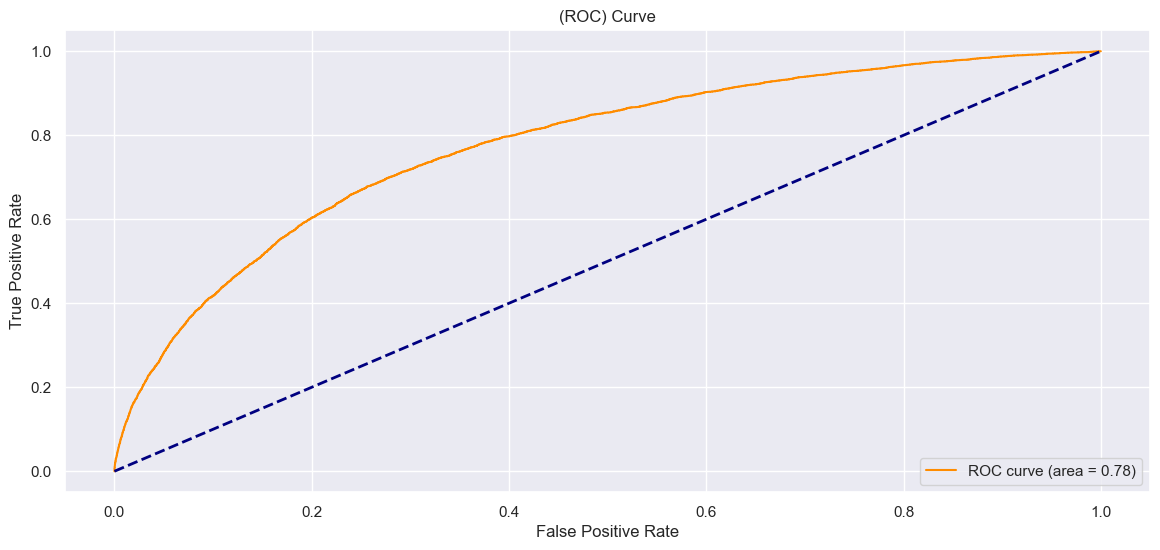

LightGBM Model AUC Valid:0.77
LightGBM Model AUC Test:0.78


<Figure size 1400x600 with 0 Axes>

In [63]:
plot_utils.plot_roc(y_test, y_pred_test)

print(f"LightGBM Model AUC Valid:{auc_all_valid:.2f}")
print(f"LightGBM Model AUC Test:{auc_all_test:.2f}")

### Model Without Pipeline

In [64]:
y = data_train["TARGET"]
x = data_train.drop(columns=["TARGET"]).reset_index(drop=True)   

x_train, x_test, x_valid, y_train, y_test, y_valid = train_test_valid_split(
    x, y, 
    test_split_size=0.2, 
    ran_state=RANDOM_STATE, 
    size=1
)

Training set shape: (184506, 343)
Validation set shape: (61502, 343)
Test set shape: (61503, 343)


In [65]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2024-10-13 21:35:58,225] A new study created in memory with name: no-name-ac8f8dda-7515-4cee-961e-9086863c53cb
[I 2024-10-13 21:36:02,672] Trial 0 finished with value: 0.7564688675122091 and parameters: {'num_leaves': 30, 'learning_rate': 0.03597115732099005, 'max_depth': 9, 'feature_fraction': 0.5073941262119623, 'bagging_fraction': 0.7076949660454228, 'bagging_freq': 4, 'n_estimators': 100}. Best is trial 0 with value: 0.7564688675122091.
[I 2024-10-13 21:36:35,946] Trial 1 finished with value: 0.7468564793571271 and parameters: {'num_leaves': 104, 'learning_rate': 0.09796682933125982, 'max_depth': 8, 'feature_fraction': 0.8627044432497024, 'bagging_fraction': 0.8420184564898712, 'bagging_freq': 4, 'n_estimators': 800}. Best is trial 0 with value: 0.7564688675122091.
[I 2024-10-13 21:36:53,036] Trial 2 finished with value: 0.7607090801573124 and parameters: {'num_leaves': 69, 'learning_rate': 0.08490107524372367, 'max_depth': 6, 'feature_fraction': 0.7385859257415401, 'bagging_fra

In [66]:
# Train the model with custom features 
model_no_pipeline = LGBMClassifier(**study.best_params, verbose=-1, random_state=RANDOM_STATE)

model_no_pipeline.fit(x_train, y_train)

LGBMClassifier(bagging_fraction=0.8750293130495569, bagging_freq=2,
               feature_fraction=0.7924769733291787,
               learning_rate=0.10345534037854838, max_depth=3, n_estimators=350,
               num_leaves=143, random_state=42, verbose=-1)

In [67]:
y_pred_npipe_valid = model_no_pipeline.predict_proba(x_valid)[:, 1]
auc_custom_valid = roc_auc_score(y_valid, y_pred_npipe_valid)

y_pred_npipe_test = model_no_pipeline.predict_proba(x_test)[:, 1]
auc_custom_test = roc_auc_score(y_test, y_pred_npipe_test)

feature_count = x_train.shape[1]
model_scores.append(
    ("LGBMClassifier All Features No Pipeline", 
     auc_custom_valid, auc_custom_test, feature_count)
)

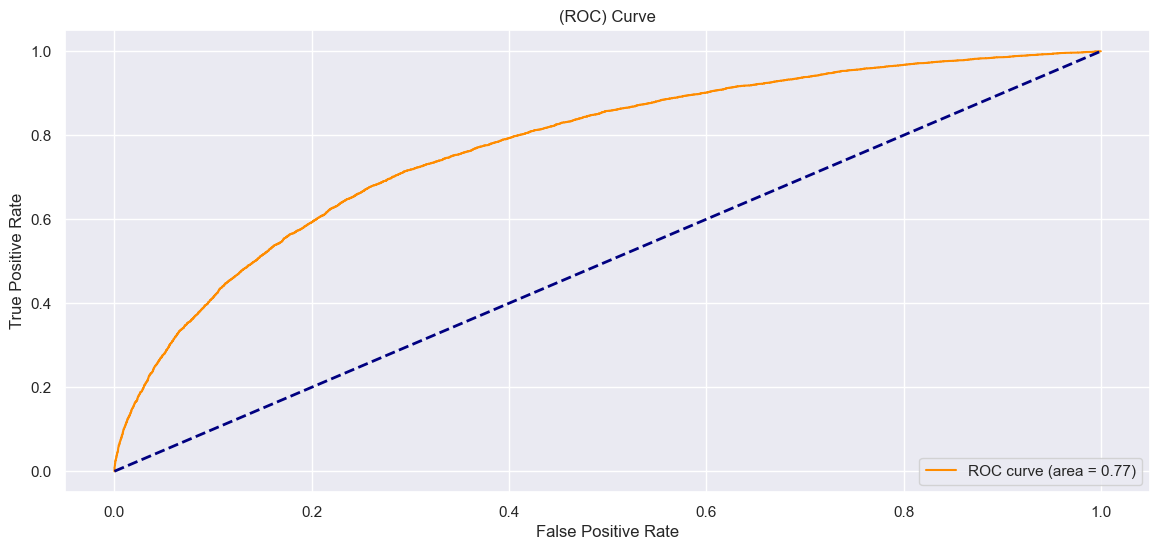

LightGBM Model AUC Valid:0.77
LightGBM Model AUC Test:0.77


<Figure size 1400x600 with 0 Axes>

In [68]:
plot_utils.plot_roc(y_test, y_pred_npipe_test)

print(f"LightGBM Model AUC Valid:{auc_custom_valid:.2f}")
print(f"LightGBM Model AUC Test:{auc_custom_test:.2f}")

#### Feature Importance

In [69]:
shap.initjs()

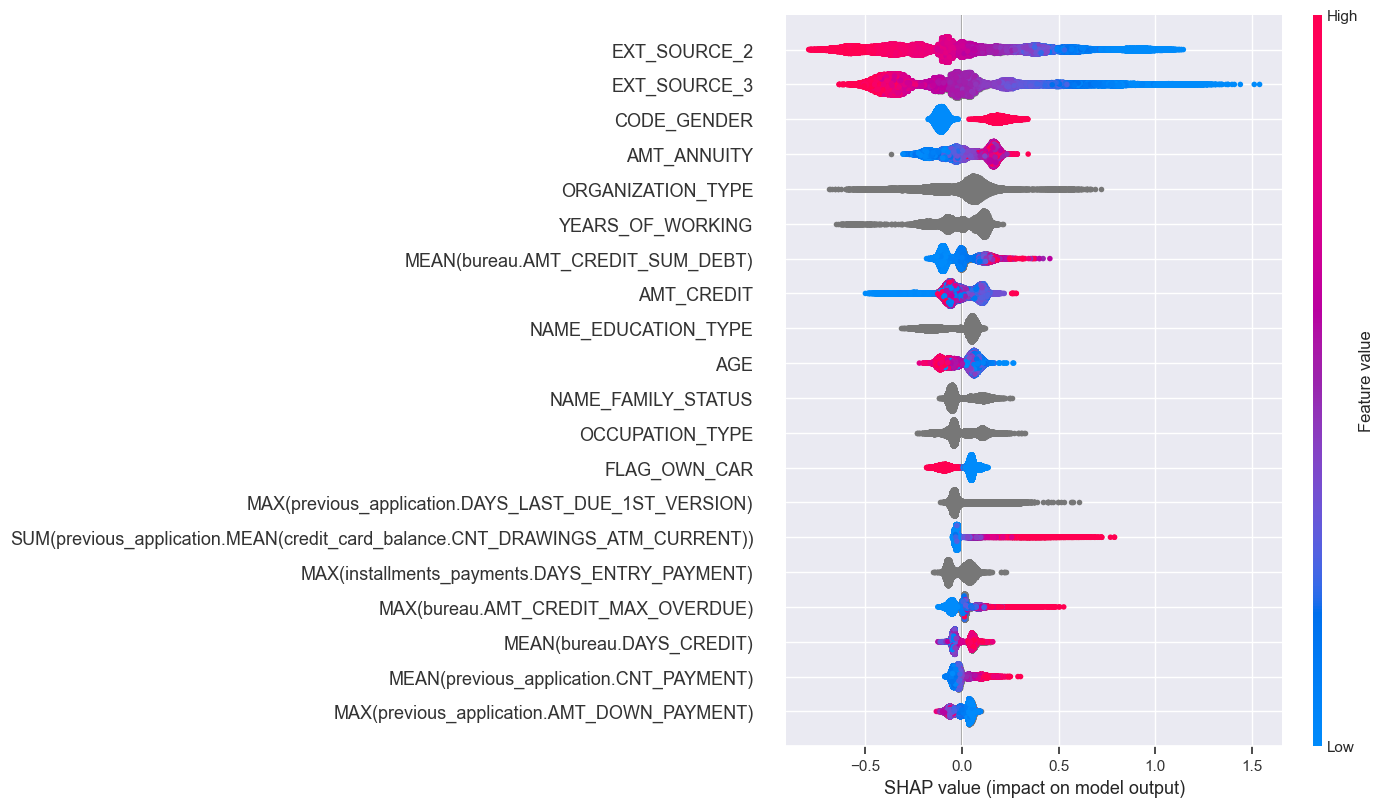

In [70]:
explainer = shap.TreeExplainer(model_no_pipeline)

shap_values = explainer.shap_values(x_valid)
shap.summary_plot(shap_values, x_valid, feature_names=x_train.columns)

### Model With Selected Features
<br>
As we already check features by importance let's use only top features which have importance more or equal 40 and are not generated by feature tools.

In [71]:
important_features[important_features["Importance"] >= 40]

,Feature,Importance
0,ORGANIZATION_TYPE,641.0
1,OCCUPATION_TYPE,195.0
2,EXT_SOURCE_3,123.0
3,EXT_SOURCE_2,115.0
4,AMT_CREDIT,90.0
5,AMT_ANNUITY,77.0
6,MAX(bureau.DAYS_CREDIT),75.0
7,MAX(bureau.DAYS_ENDDATE_FACT),64.0
8,MAX(previous_application.DAYS_LAST_DUE),64.0
9,MAX(bureau.DAYS_CREDIT_ENDDATE),57.0


We will exclude Age at it was generated from DAYS_BIRTH, we will use only raw and important features.

In [72]:
custom_data = [
    "DAYS_LAST_PHONE_CHANGE", "TOTALAREA_MODE", 
    "WEEKDAY_APPR_PROCESS_START", "AMT_ANNUITY", 
    "AMT_CREDIT", "EXT_SOURCE_2", "EXT_SOURCE_3", 
    "OCCUPATION_TYPE", "ORGANIZATION_TYPE"]

x_custom = data_train[custom_data]
y_custom = data_train["TARGET"]

x_train, x_test, x_valid, y_train, y_test, y_valid = train_test_valid_split(x_custom, y_custom, test_split_size=0.2, ran_state=RANDOM_STATE, size=1)

Training set shape: (184506, 9)
Validation set shape: (61502, 9)
Test set shape: (61503, 9)


In [73]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2024-10-13 21:38:11,307] A new study created in memory with name: no-name-9c3ff881-af0a-4d3d-8258-67babeb5f20c
[I 2024-10-13 21:38:15,546] Trial 0 finished with value: 0.6830868523194918 and parameters: {'num_leaves': 71, 'learning_rate': 0.1844572774182319, 'max_depth': 6, 'feature_fraction': 0.5145093443365214, 'bagging_fraction': 0.5296311583488578, 'bagging_freq': 6, 'n_estimators': 900}. Best is trial 0 with value: 0.6830868523194918.
[I 2024-10-13 21:38:16,726] Trial 1 finished with value: 0.7232155769410229 and parameters: {'num_leaves': 103, 'learning_rate': 0.15631565094754443, 'max_depth': 5, 'feature_fraction': 0.5242809872321523, 'bagging_fraction': 0.8837441634694194, 'bagging_freq': 2, 'n_estimators': 250}. Best is trial 1 with value: 0.7232155769410229.
[I 2024-10-13 21:38:21,528] Trial 2 finished with value: 0.6790824484980658 and parameters: {'num_leaves': 83, 'learning_rate': 0.1611380982636517, 'max_depth': 10, 'feature_fraction': 0.7251618822726347, 'bagging_frac

In [74]:
model_custom_features = LGBMClassifier(**study.best_params, verbose=-1, random_state=RANDOM_STATE)

model_custom_features.fit(x_train, y_train)

LGBMClassifier(bagging_fraction=0.522294484247898, bagging_freq=5,
               feature_fraction=0.8595469575479439,
               learning_rate=0.04005211239149918, max_depth=3, n_estimators=350,
               num_leaves=137, random_state=42, verbose=-1)

In [75]:
y_pred_custom_valid = model_custom_features.predict_proba(x_valid)[:, 1]
auc_custom_valid = roc_auc_score(y_valid, y_pred_custom_valid)

y_pred_custom_test = model_custom_features.predict_proba(x_test)[:, 1]
auc_custom_test = roc_auc_score(y_test, y_pred_custom_test)

feature_count = x_train.shape[1]
model_scores.append(
    ("LGBMClassifier Raw Data No Pipeline Important Features", 
     auc_custom_valid, auc_custom_test, feature_count)
)

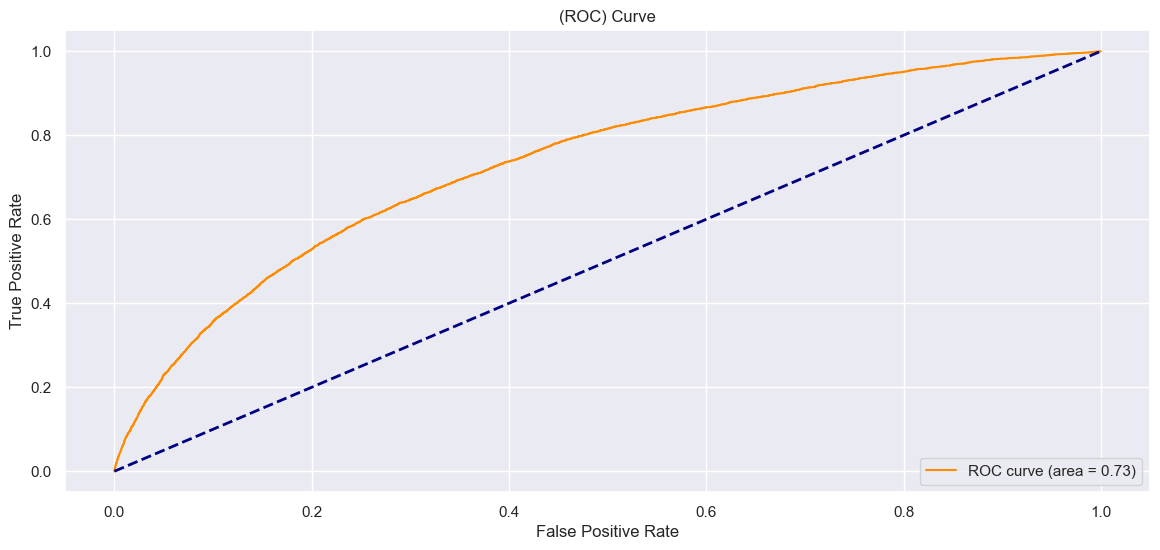

LightGBM Model AUC Valid:0.73
LightGBM Model AUC Test:0.73


<Figure size 1400x600 with 0 Axes>

In [76]:
plot_utils.plot_roc(y_test, y_pred_custom_test)

print(f"LightGBM Model AUC Valid:{auc_custom_valid:.2f}")
print(f"LightGBM Model AUC Test:{auc_custom_test:.2f}")

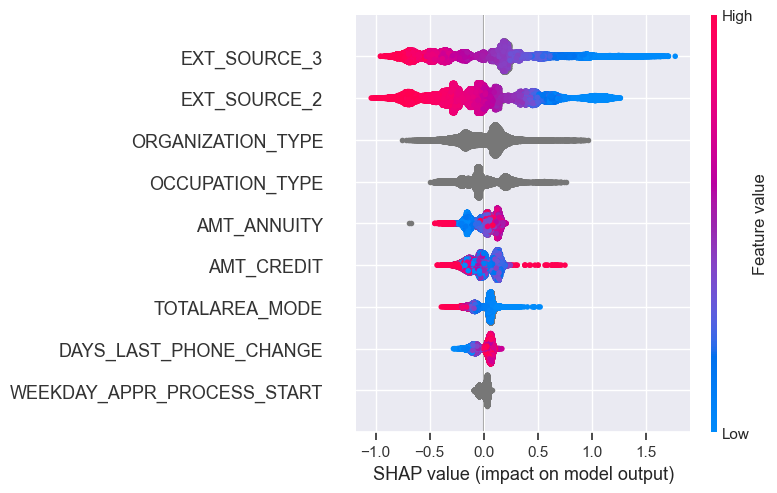

In [77]:
explainer = shap.TreeExplainer(model_custom_features)

shap_values = explainer.shap_values(x_valid)
shap.summary_plot(shap_values, x_valid, feature_names=x_train.columns)

In [78]:
model_scores_df = pd.DataFrame(
    model_scores, 
    columns=[
        "Name", 
        "Validation Score", 
        "Test Score", 
        "Feature Count"]
)

model_scores_df

,Name,Validation Score,Test Score,Feature Count
0,LGBMClassifier Features + Pipeline,0.772145,0.775922,343
1,LGBMClassifier All Features No Pipeline,0.771331,0.774385,343
2,LGBMClassifier Raw Data No Pipeline Important ...,0.729151,0.734692,9


## Model export
<br>
While using features from all tables, combining with pipeline, we don't see big difference over model without pipeline or without pipeline and new features. Using raw data for LGBM Classifier works almost the same, so we will deploy select simpler model for deployment.

In [79]:
export_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", 
         OneHotEncoder(), 
         ["WEEKDAY_APPR_PROCESS_START", "OCCUPATION_TYPE", "ORGANIZATION_TYPE"]
        )
    ]
)

export_pipe = Pipeline(steps=[
    ("preprocessor", export_preprocessor), 
    ("model", model_custom_features)])

In [80]:
export_pipe.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['WEEKDAY_APPR_PROCESS_START',
                                                   'OCCUPATION_TYPE',
                                                   'ORGANIZATION_TYPE'])])),
                ('model',
                 LGBMClassifier(bagging_fraction=0.522294484247898,
                                bagging_freq=5,
                                feature_fraction=0.8595469575479439,
                                learning_rate=0.04005211239149918, max_depth=3,
                                n_estimators=350, num_leaves=137,
                                random_state=42, verbose=-1))])

As our model is trained with data we can export it to file.

In [83]:
model_path = f"{path_models}/model.sav"
joblib.dump(export_pipe, model_path)

['app/models/model.sav']

## Summary

We perform feature engineering, in which we generate new features for our models. Manually, we group features to a defined list for different data types we have. By using feature tools, we combine all tables by creating connections to them. We save a lot of time using different libraries, which did most of the job for us.
<br>
<li>We remove highly nullable features - 50% and more.</li>
<li>We didn't find any duplicate values in the dataset.</li>
<li>We remove features which have only one unique value.</li>
<li>We remove highly correlated features.</li>
<li>We pick features which XGBoost classified as an important one, for baseline we take everything more than 1.</li>
<li>We made a checkpoint in the middle of work if any crash appears, so we can have already created file in the middle of work.</li>
<br>
We created separate, different ML models, create transformers and pipeline which can be more efficient for ML model creation.
<li>Dummy Classifier model which was passed to pipeline.</li>
<li>Logistic Regression Model which was passed to pipeline.</li>
<li>Light Gradient Boosting Machine Model which was passed to pipeline.</li>
<br>
For the main models, we create separate models with different combination to check model performance.
<li>LGBM model which was using pipeline and all features.</li>
<li>LGBM model which not using pipeline but have all features.</li>
<li>LGBM model which use top features of feature importance check.</li>
<br>
All models have similar ROC curve, having AUC about ~0.75.
<li>We will export simpler model for time-consuming, as performance is not very different with other models.</li>


## Suggestion For Improvement

<li>Try ensemble methods that combine the strengths of different models.</li>
<li>Try Neural Networks</li>
<li>Go deeper to each feature and try to find more connections between features to fill null values.</li>